## A guide to handling categorical variables in supervised machine learning

Basic data exploration

In [39]:
import pandas as pd 
import matplotlib.pyplot as plt
% matplotlib inline

In [40]:
train=pd.read_csv("C:\\Users\\HITESH SINGH\\Desktop\\dataset\\animal prediction\\train.csv")

In [41]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


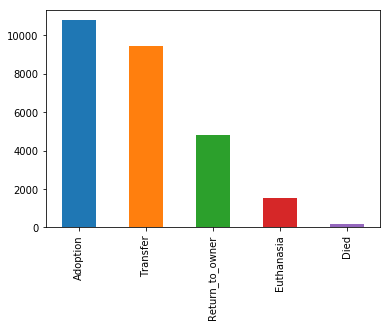

In [42]:
train['OutcomeType'].value_counts().plot.bar()

In [43]:
train.dtypes

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

## Checking unique values

In [44]:
columns=train.columns
for column in columns:
    print(column)
    print(train[column].nunique())

AnimalID
26729
Name
6374
DateTime
22918
OutcomeType
5
OutcomeSubtype
16
AnimalType
2
SexuponOutcome
5
AgeuponOutcome
44
Breed
1380
Color
366


In [45]:
train.apply(lambda x: sum(x.isnull()/len(train)))

AnimalID          0.000000
Name              0.287740
DateTime          0.000000
OutcomeType       0.000000
OutcomeSubtype    0.509260
AnimalType        0.000000
SexuponOutcome    0.000037
AgeuponOutcome    0.000673
Breed             0.000000
Color             0.000000
dtype: float64

In [46]:
train.isnull().sum().sum()

21322

In [47]:
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

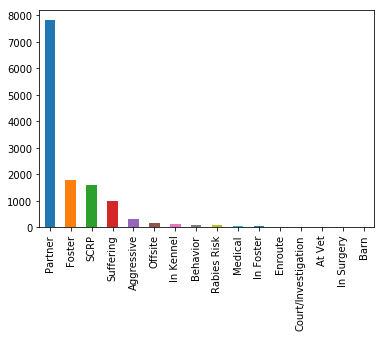

In [48]:
train['OutcomeSubtype'].value_counts().plot.bar()

we can say that outcomesubtype and name have highest missing values 

In [49]:
train=train.drop('OutcomeSubtype',axis=1)

Missing data in the “Name” field could well turn out to have some impact on the outcome of an animal

In [50]:
train['Name']=train[['Name']].fillna(value=0)
train['has_name']=(train['Name']!=0).astype('int64')
train=train.drop('Name',axis=1)

In [51]:
train = train.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [52]:
train.apply(lambda x: sum(x.isnull()/len(train)))

AnimalID          0.0
DateTime          0.0
OutcomeType       0.0
AnimalType        0.0
SexuponOutcome    0.0
AgeuponOutcome    0.0
Breed             0.0
Color             0.0
has_name          0.0
dtype: float64

In [53]:
train.isnull().sum()

AnimalID          0
DateTime          0
OutcomeType       0
AnimalType        0
SexuponOutcome    0
AgeuponOutcome    0
Breed             0
Color             0
has_name          0
dtype: int64

## Finally I am going to drop the AnimalID column as that will not be useful in the model.

In [54]:
train=train.drop('AnimalID',axis=1)

In [59]:
color_counts=train['Color'].value_counts()
color_others = set(color_counts[color_counts < 300].index)
train['top_colors'] = train['Color'].replace(list(color_others), 'Others')
print(train['top_colors'].nunique())

28


In [60]:
import re
train['breed_type'] = train.Breed.str.extract('({})'.format('|'.join(['Mix'])), 
                        flags=re.IGNORECASE, expand=False).str.lower().fillna('pure')

In [61]:
train['multi_colors'] = train['Color'].apply(lambda x : 1 if '/' in x else 0)

In [62]:
def age_converter(row):
    age_string = row['AgeuponOutcome']
    [age,unit] = age_string.split(" ")
    unit = unit.lower()
    if("day" in unit):
        if age=='0': return 1
        return int(age)
    if("week" in unit):
        if(age)=='0': return 7
        return int(age)*7
    elif("month" in unit):
        if(age)=='0': return 30
        return int(age) * 4*7
    elif("year" in unit):
        if(age)=='0': return 365
        return int(age) * 4*12*7
train['age_numeric'] = train.apply(age_converter, axis=1)
train = train.drop('AgeuponOutcome', axis=1)

In [63]:
train = train.drop(['Breed','Color', 'DateTime'], axis=1)
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train.select_dtypes(include=['object']).drop(['OutcomeType'], axis=1).columns
dummy_columns = pd.get_dummies(train[categorical_features])
final_train = pd.concat([dummy_columns, train],axis=1)
final_train = final_train.drop(['AnimalType', 'breed_type', 'SexuponOutcome', 'top_colors'], axis=1)

## Training classifier

In [64]:
X = final_train.drop('OutcomeType', axis=1)
y = final_train['OutcomeType']

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## using a simple RandomForestClassifier 

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                            random_state=0)
rf_model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
y_prob = rf_model.predict_proba(X_test)
print(log_loss(y_test, y_prob))

C:\Users\HITESH SINGH\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.5948372615039281
1.0822259028580448


<function matplotlib.pyplot.show(*args, **kw)>

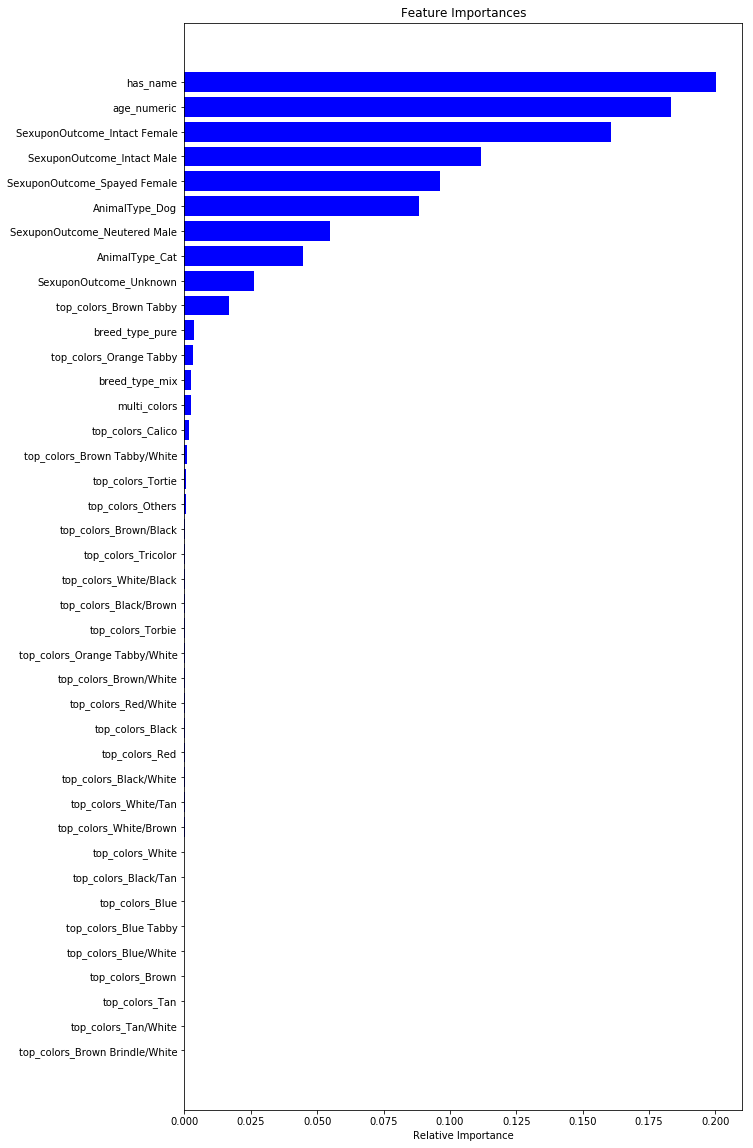

In [67]:
import numpy as np
features=X.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show